In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Flatten, Input
from tensorflow.keras.models import Model
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from tabnet_keras import TabNetRegressor, TabNetClassifier





In [2]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)
from config.config import *
# from libs.common import *

c:\Users\Admin\Data\ads_fraud_detection
c:/Users/Admin/Data/ads_fraud_detection


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print('Using GPU:', gpus[0])  # In ra tên của GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
else:
    print('No GPU found. Using CPU.')


No GPU found. Using CPU.


In [4]:
save_dir=f"{exps_dir}/exp2/exp_gan"
if os.path.exists(save_dir) == False: 
  os.makedirs(save_dir, exist_ok=True)



test_size=0.33
seed=42

In [5]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')


In [6]:
print(x_train.shape, y_train.shape)

(20422, 34) (20422, 1)


In [7]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train.FraudFound_P), y=y_train.FraudFound_P)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}
class_weights_dict

{0: 1.0510550694801852, 1: 0.9536751657793967}

In [8]:


def oneHot(arr):
    labels = np.array(arr)
    encoder = OneHotEncoder(sparse_output=False)
    
    labels_reshaped = labels.reshape(-1, 1)
    
    encoder.fit(labels_reshaped)
    
    onehot_labels = encoder.transform(labels_reshaped)
    return onehot_labels

y_train_onehot=oneHot(y_train)
y_test_onehot=oneHot(y_test)
print(y_test_onehot.shape,y_train_onehot.shape)


(5089, 2) (20422, 2)


In [9]:
def f1_score(y_true, y_pred):
    """
    Macro F1 score metric.
    """
    y_pred = K.round(y_pred)    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=0)
    false_negatives = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=0)    
    precision = true_positives / (true_positives + false_positives + K.epsilon())
    recall = true_positives / (true_positives + false_negatives + K.epsilon())    
    f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())    
    macro_f1_score = K.mean(f1_scores)
    
    return macro_f1_score

In [10]:
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    loss = -tf.reduce_mean(alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt))
    return loss


In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred, smooth=0.0001):
    return 1 - dice_coef(y_true, y_pred, smooth)

In [12]:
def f1_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    predicted_positives = tf.reduce_sum(y_pred, axis=0)
    possible_positives = tf.reduce_sum(y_true, axis=0)
    precision = tp / (predicted_positives + tf.keras.backend.epsilon())
    recall = tp / (possible_positives + tf.keras.backend.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    f1_macro = tf.reduce_mean(f1)
    return 1 - f1_macro

In [13]:
def multi_loss(y_true, y_pred):
    # # Tính toán các loss function riêng lẻ
    focal__loss = focal_loss(y_true,y_pred)
    f1__loss = f1_loss(y_true,y_pred)
    dice__loss = dice_coef_loss(y_true,y_pred)
    focal_weight = 0.3
    f1_weight = 0.5
    dice_weight = 0.2

    total_loss = (focal_weight * focal__loss) + (f1_weight * f1__loss) + (dice_weight * dice__loss)

    return total_loss

In [14]:
learning_rate=0.0001
tabnet_params = {
    "decision_dim": 16,
    "attention_dim": 16,
    "n_steps": 3,
    "n_shared_glus": 2,
    "n_dependent_glus": 2,
    "relaxation_factor": 1.3,
    "epsilon": 1e-15,
    "momentum": 0.98,
    "mask_type": "softmax", # can be 'sparsemax' or 'softmax'
    "lambda_sparse": 1e-3, 
    "virtual_batch_splits": 8 #number of splits for ghost batch normalization, ideally should evenly divide the batch_size
}



### Classification
model = TabNetClassifier(n_classes = 2, out_activation = 'softmax', **tabnet_params)

In [15]:
import keras_cv

Using TensorFlow backend


In [16]:
keras_cv.losses.FocalLoss(
    alpha=0.25, gamma=2, from_logits=False, label_smoothing=0
)

In [17]:
early_stopping = EarlyStopping(monitor='val_loss',
    min_delta=0.00005,
    patience=60,
    verbose=1,
    restore_best_weights=True,
)

model_checkpoint = ModelCheckpoint('best_model', monitor='val_loss', save_best_only=True, save_format='tf')


lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=20,
    min_lr=0.000001,
    verbose=1,
)

In [18]:
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
# model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), loss=f1_loss, metrics=['accuracy',f1_score])
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), loss=keras_cv.losses.FocalLoss(
    alpha=0.25, gamma=2, from_logits=False, label_smoothing=0
), metrics=['accuracy',f1_score])
# model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), loss=dice_coef_loss, metrics=['accuracy',f1_score])
# model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), loss=multi_loss, metrics=['accuracy',f1_score])

In [19]:
# model.summary()

In [20]:
model.fit(x=x_train,y=y_train_onehot,
          validation_data=(x_test,y_test_onehot),
          batch_size=64,epochs= 1200, class_weight={0:1,1:5.5}, callbacks=[early_stopping,lr_scheduler])


Epoch 1/1200
320/320 [==============================] - 41s 14ms/step - loss: 0.2179 - accuracy: 0.6903 - f1_score: 0.6533 - val_loss: 0.1884 - val_accuracy: 0.6654 - val_f1_score: 0.4800 - lr: 0.0010
Epoch 2/1200
320/320 [==============================] - 5s 14ms/step - loss: 0.1518 - accuracy: 0.7766 - f1_score: 0.7630 - val_loss: 0.1712 - val_accuracy: 0.7147 - val_f1_score: 0.5094 - lr: 0.0010
Epoch 3/1200
320/320 [==============================] - 5s 15ms/step - loss: 0.1387 - accuracy: 0.7944 - f1_score: 0.7831 - val_loss: 0.1465 - val_accuracy: 0.6665 - val_f1_score: 0.4956 - lr: 0.0010
Epoch 4/1200
320/320 [==============================] - 5s 15ms/step - loss: 0.1298 - accuracy: 0.7969 - f1_score: 0.7865 - val_loss: 0.1239 - val_accuracy: 0.6797 - val_f1_score: 0.4981 - lr: 0.0010
Epoch 5/1200
320/320 [==============================] - 5s 15ms/step - loss: 0.1238 - accuracy: 0.8053 - f1_score: 0.7944 - val_loss: 0.1454 - val_accuracy: 0.5991 - val_f1_score: 0.4673 - lr: 0.0010

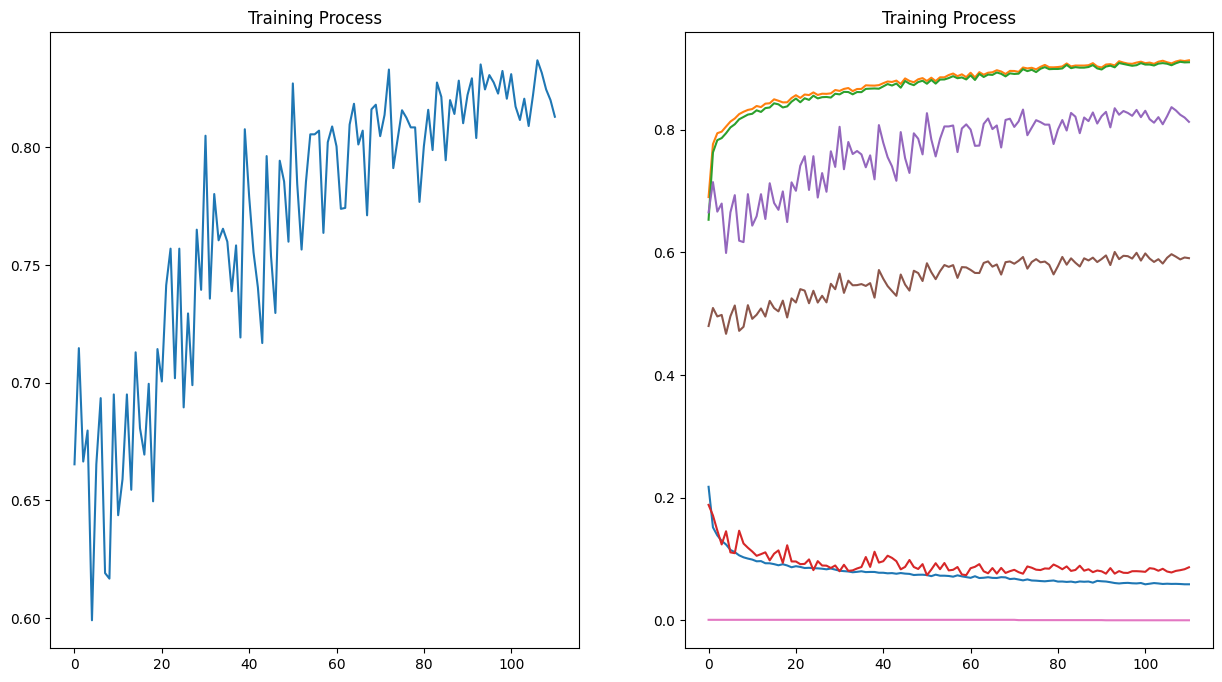

<Figure size 640x480 with 0 Axes>

In [21]:
history=model.history.history
fig,axes=plt.subplots(1,2, figsize=(15,8))
axes[0].plot(pd.DataFrame(history['val_accuracy']))
axes[0].set_title('Training Process')
axes[1].plot(pd.DataFrame(history))
axes[1].set_title('Training Process')
plt.show()
plt.savefig('train.png')

In [22]:
y_test_labels = np.argmax(y_test_onehot, axis=1)
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_test_labels, predictions)
accuracy


160/160 [==============================] - 1s 1ms/step


0.8270780113971311

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

y_test_labels = np.argmax(y_test_onehot, axis=1)

accuracy = accuracy_score(y_test_labels, predictions)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test_labels, predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, predictions))


Accuracy: 0.8270780113971311
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.90      4782
           1       0.18      0.54      0.28       307

    accuracy                           0.83      5089
   macro avg       0.58      0.69      0.59      5089
weighted avg       0.92      0.83      0.86      5089

Confusion Matrix:
[[4042  740]
 [ 140  167]]


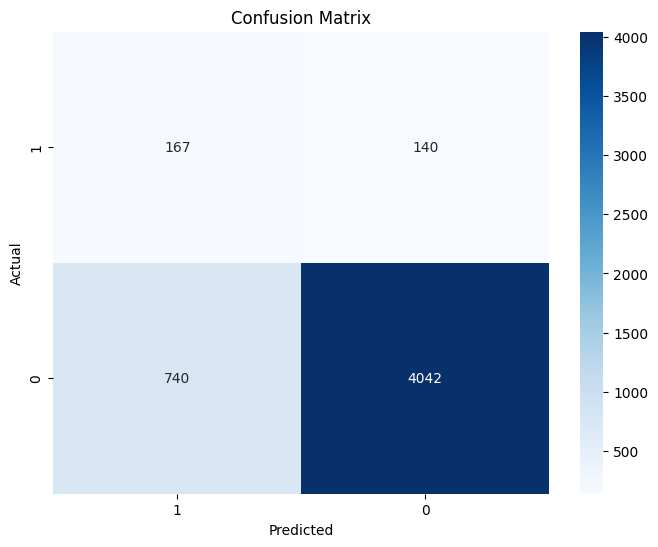

In [24]:
# Dự đoán


# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, predictions,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

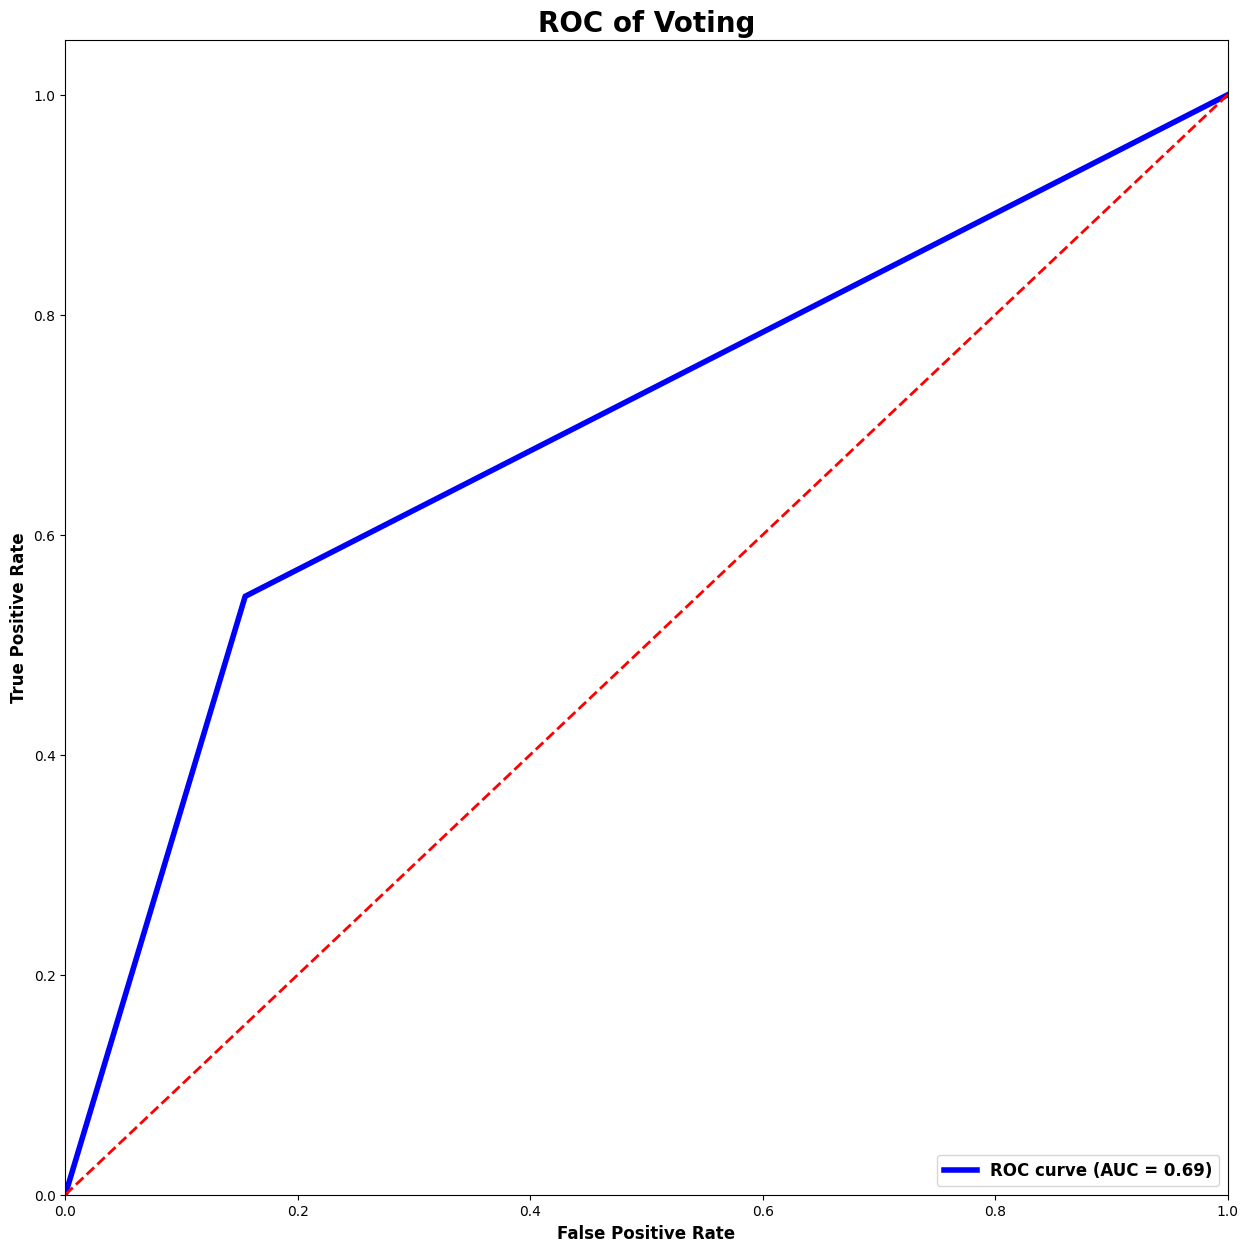

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

fpr, tpr, _ = roc_curve(y_test, predictions)
    
roc_auc = auc(fpr, tpr)

ax.plot(fpr, tpr, lw=4, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  
ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   
ax.set_title(f'ROC of Voting',fontsize=20, weight='bold')  
ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'}) 
plt.show()